In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.color import rgb2hed, hed2rgb, rgb2gray
from skimage import img_as_ubyte

In [2]:
TRAIN_DIR = 'data/train/'
TRAIN_FILES = os.listdir(TRAIN_DIR)
len(TRAIN_FILES)

220025

In [3]:
img = imread(TRAIN_DIR + TRAIN_FILES[1])
img.shape

(96, 96, 3)

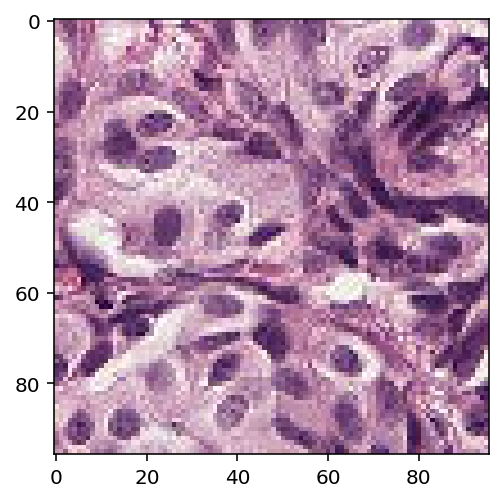

In [4]:
plt.imshow(img);

In [5]:
def show_color(img, cvt_color, max_val=(254, 254, 254)):
    max_val = [x if x > 0 else 254 for x in max_val]
    img = cv2.cvtColor(img, cvt_color)
    _, ((ax1, ax2, ax3), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(17,8))
    ax1.imshow(img[:, :, 0], cmap='gray', vmax=max_val[0]+1)
    ax2.imshow(img[:, :, 1], cmap='gray', vmax=max_val[1]+1)
    ax3.imshow(img[:, :, 2], cmap='gray', vmax=max_val[2]+1)
    ax21.hist(img[:, :, 0].ravel(), range(2, max_val[0]))
    ax22.hist(img[:, :, 1].ravel(), range(2, max_val[1]))
    ax23.hist(img[:, :, 2].ravel(), range(2, max_val[2]))

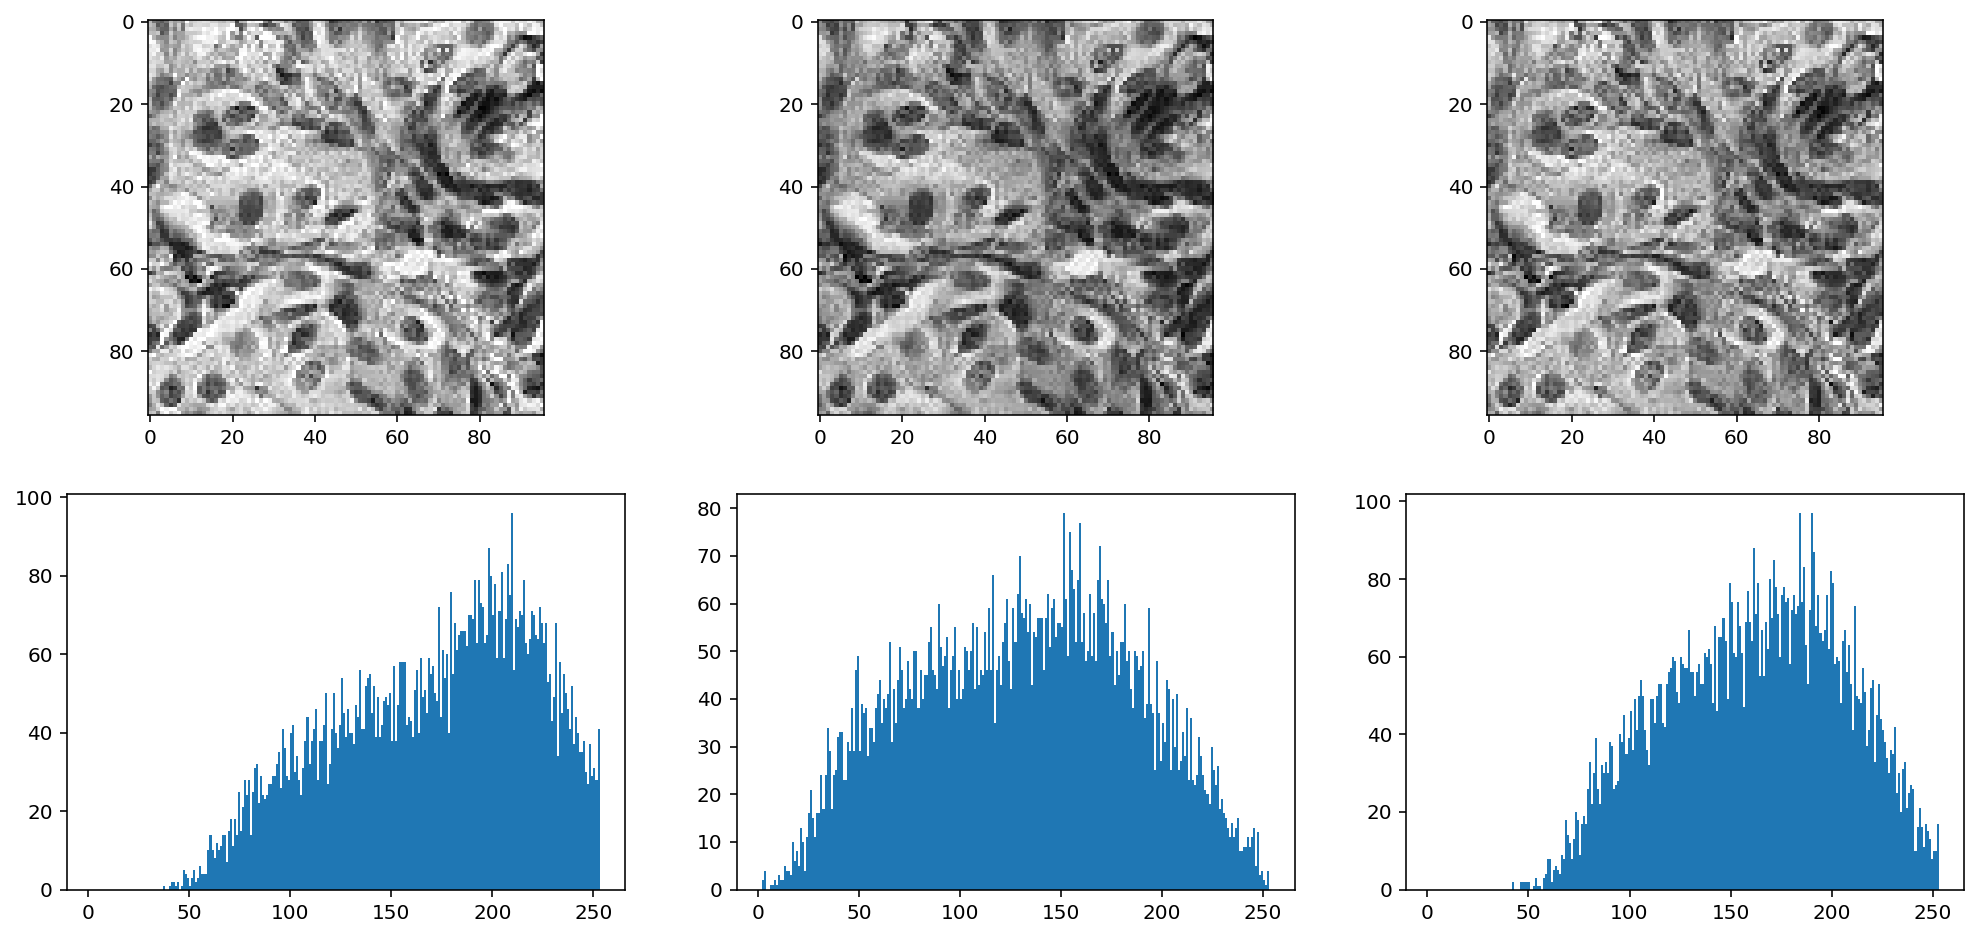

In [6]:
show_color(img, None)

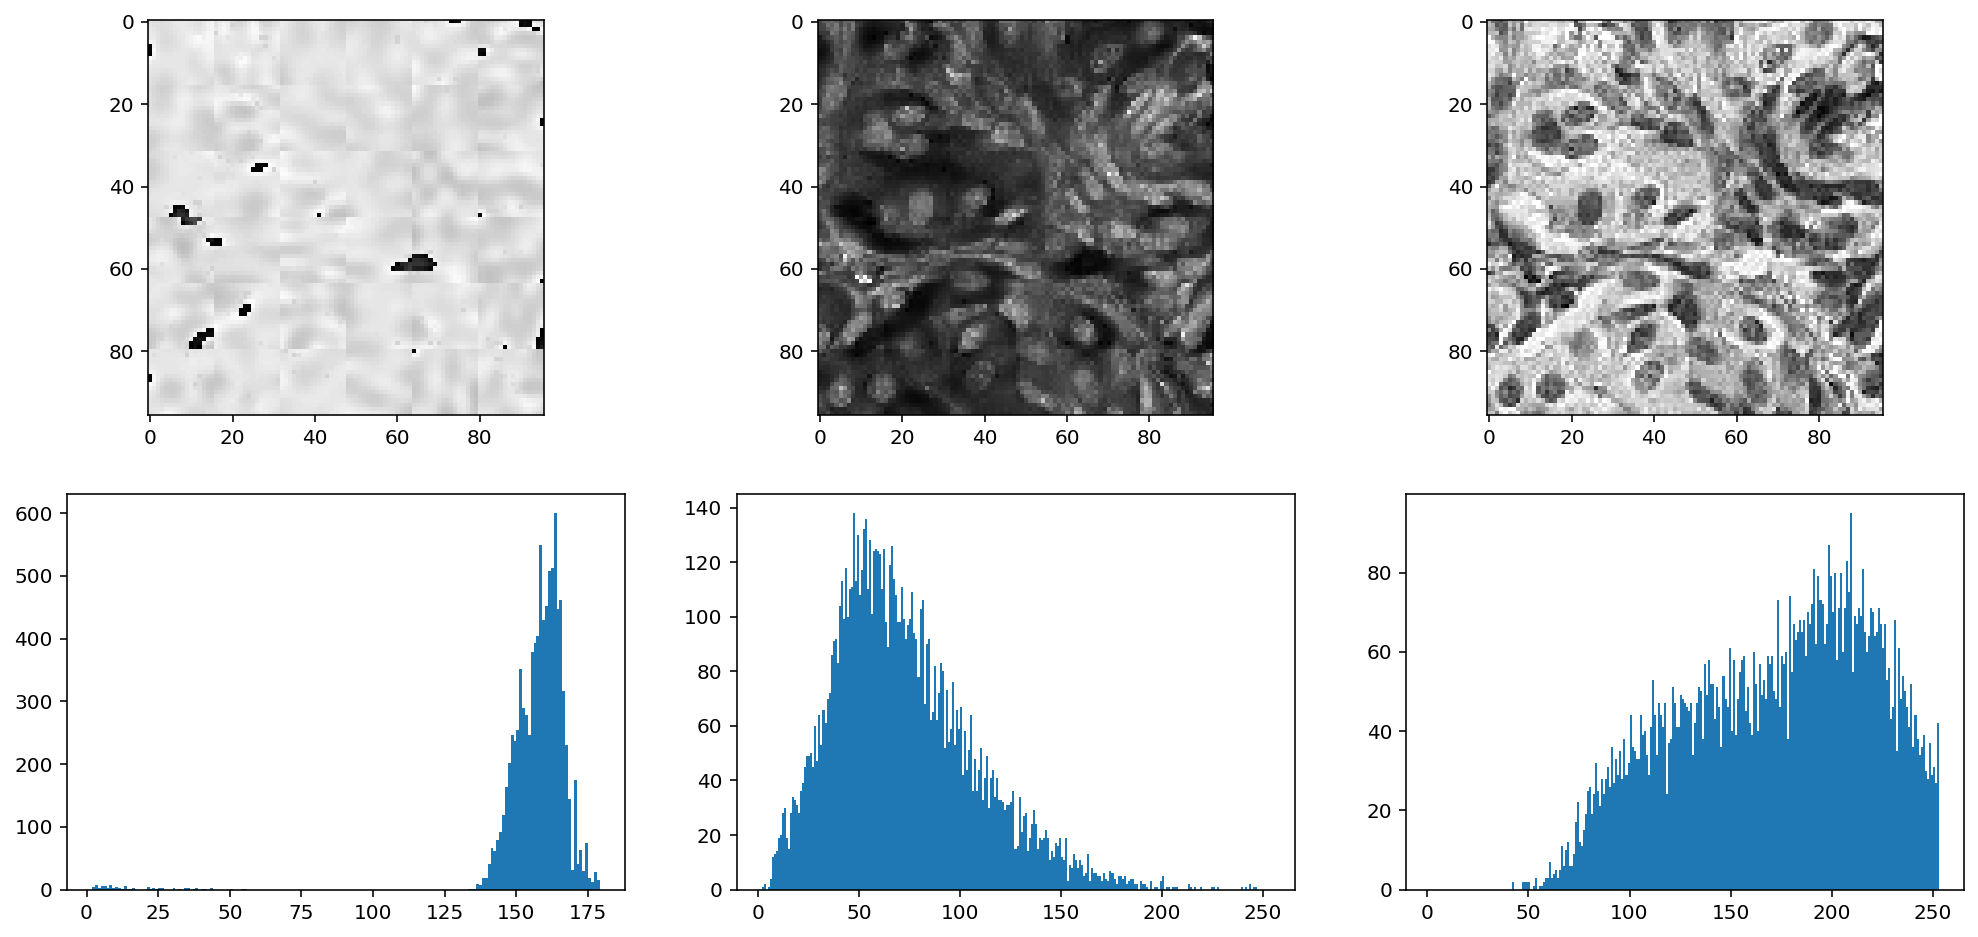

In [7]:
show_color(img, cv2.COLOR_RGB2HSV, (180, -1, -1))

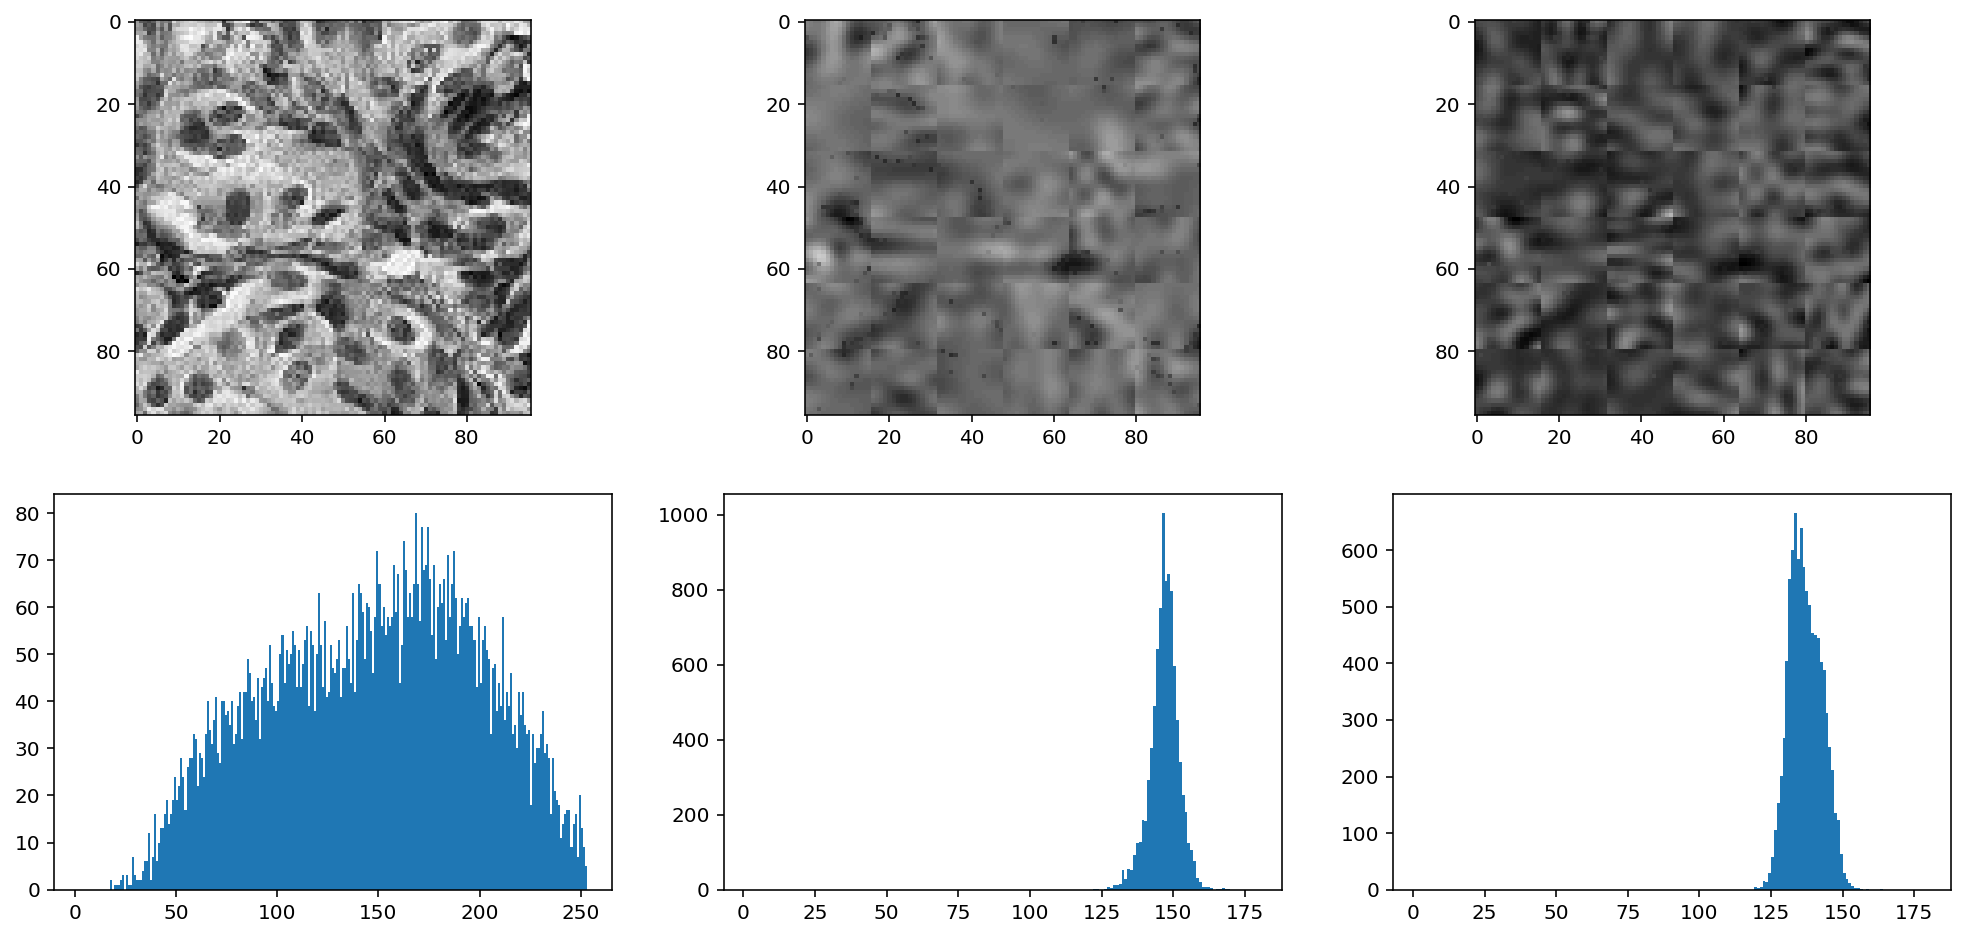

In [8]:
show_color(img, cv2.COLOR_RGB2YCrCb, (-1, 180, 180))

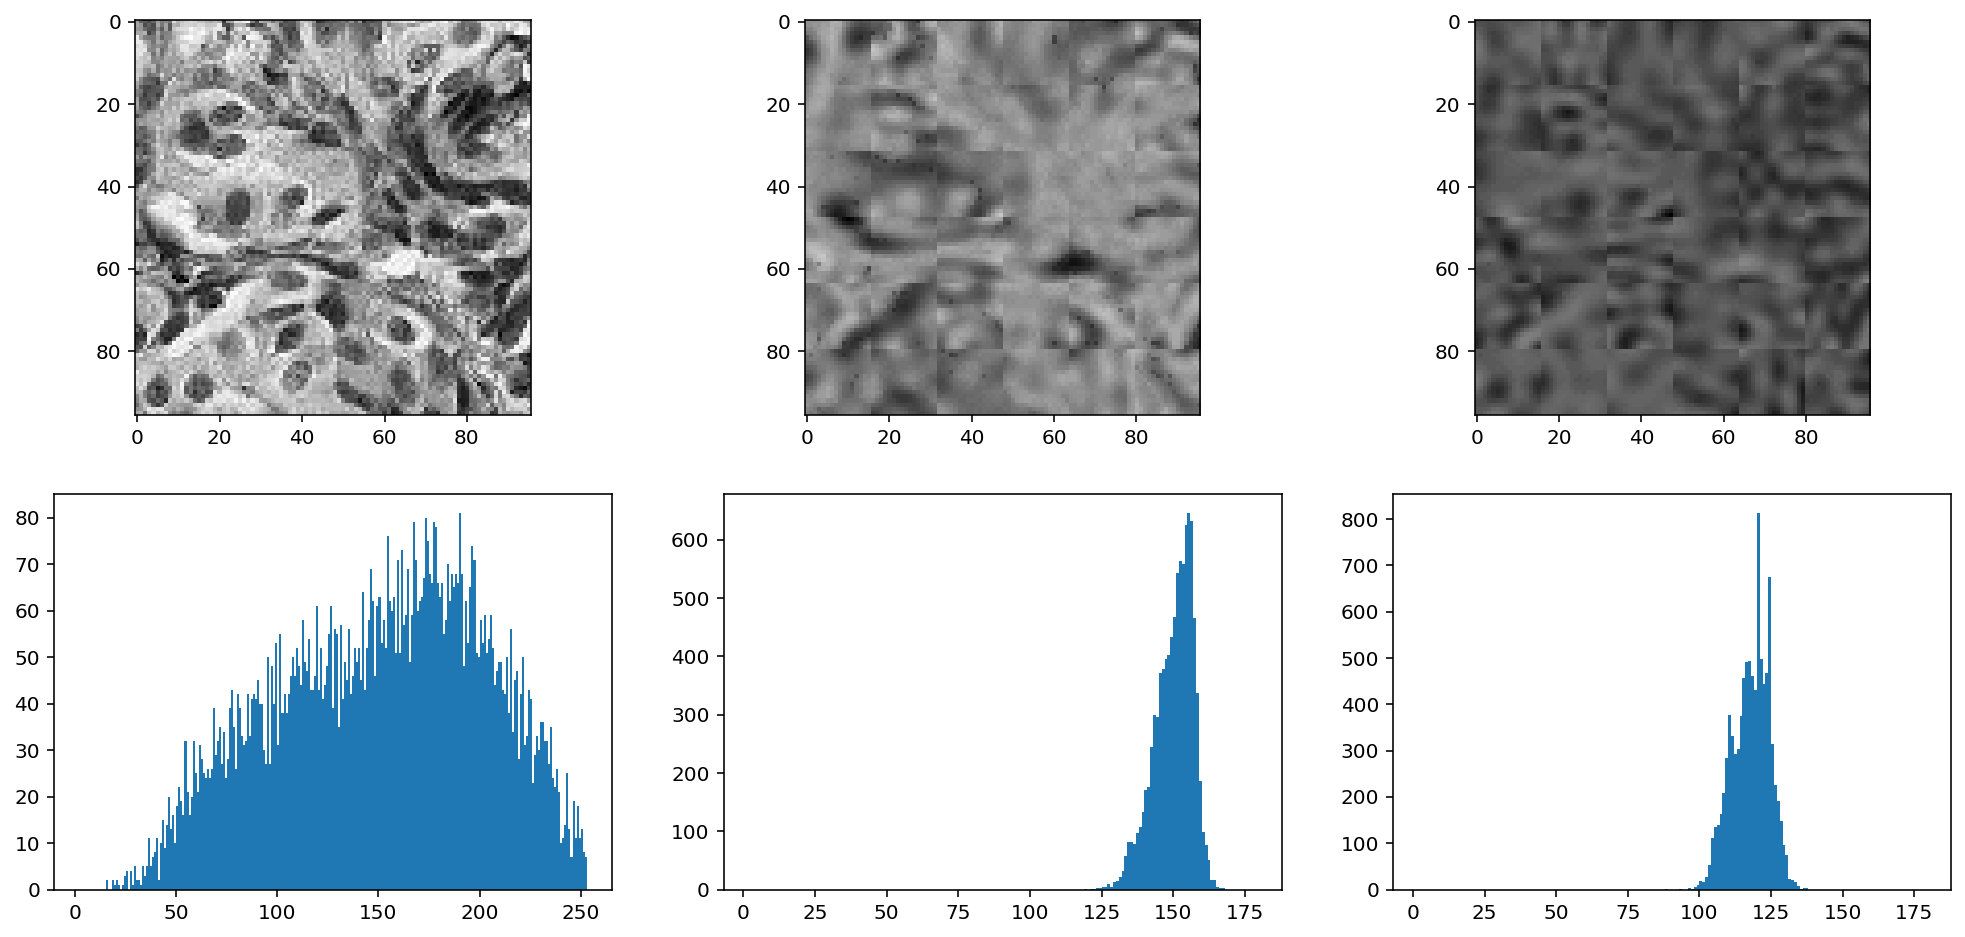

In [9]:
show_color(img, cv2.COLOR_RGB2Lab, (-1, 180, 180))

## Positive vs Negative

In [10]:
df = pd.read_csv('data/train_labels.csv')
df.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [11]:
(df['label'] == 1).value_counts()

False    130908
True      89117
Name: label, dtype: int64

In [12]:
ids = [df[df['label'] == 0]['id'].values.tolist(), df[df['label'] == 1]['id'].values.tolist()]
len(ids[0]), len(ids[1])

(130908, 89117)

In [13]:
def show8(dir: str, ids: list, title=None, cvt_color=None, chan=None):
    fig, ax = plt.subplots(2, 4, figsize=(17,8))
    for i in range(8):
        col = i % 4
        row = i // 4
        img = imread(dir + ids[i] + '.tif')
        if cvt_color:
            chans = cv2.cvtColor(img, cvt_color)
            img = chans[:, :, chan]
            cmap = 'gray'
        else:
            cmap = None
        ax[row][col].axis('off')
        ax[row][col].set_title(f'{ids[i][:5]}')
        ax[row][col].imshow(img, cmap=cmap)
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()

### Negative Images

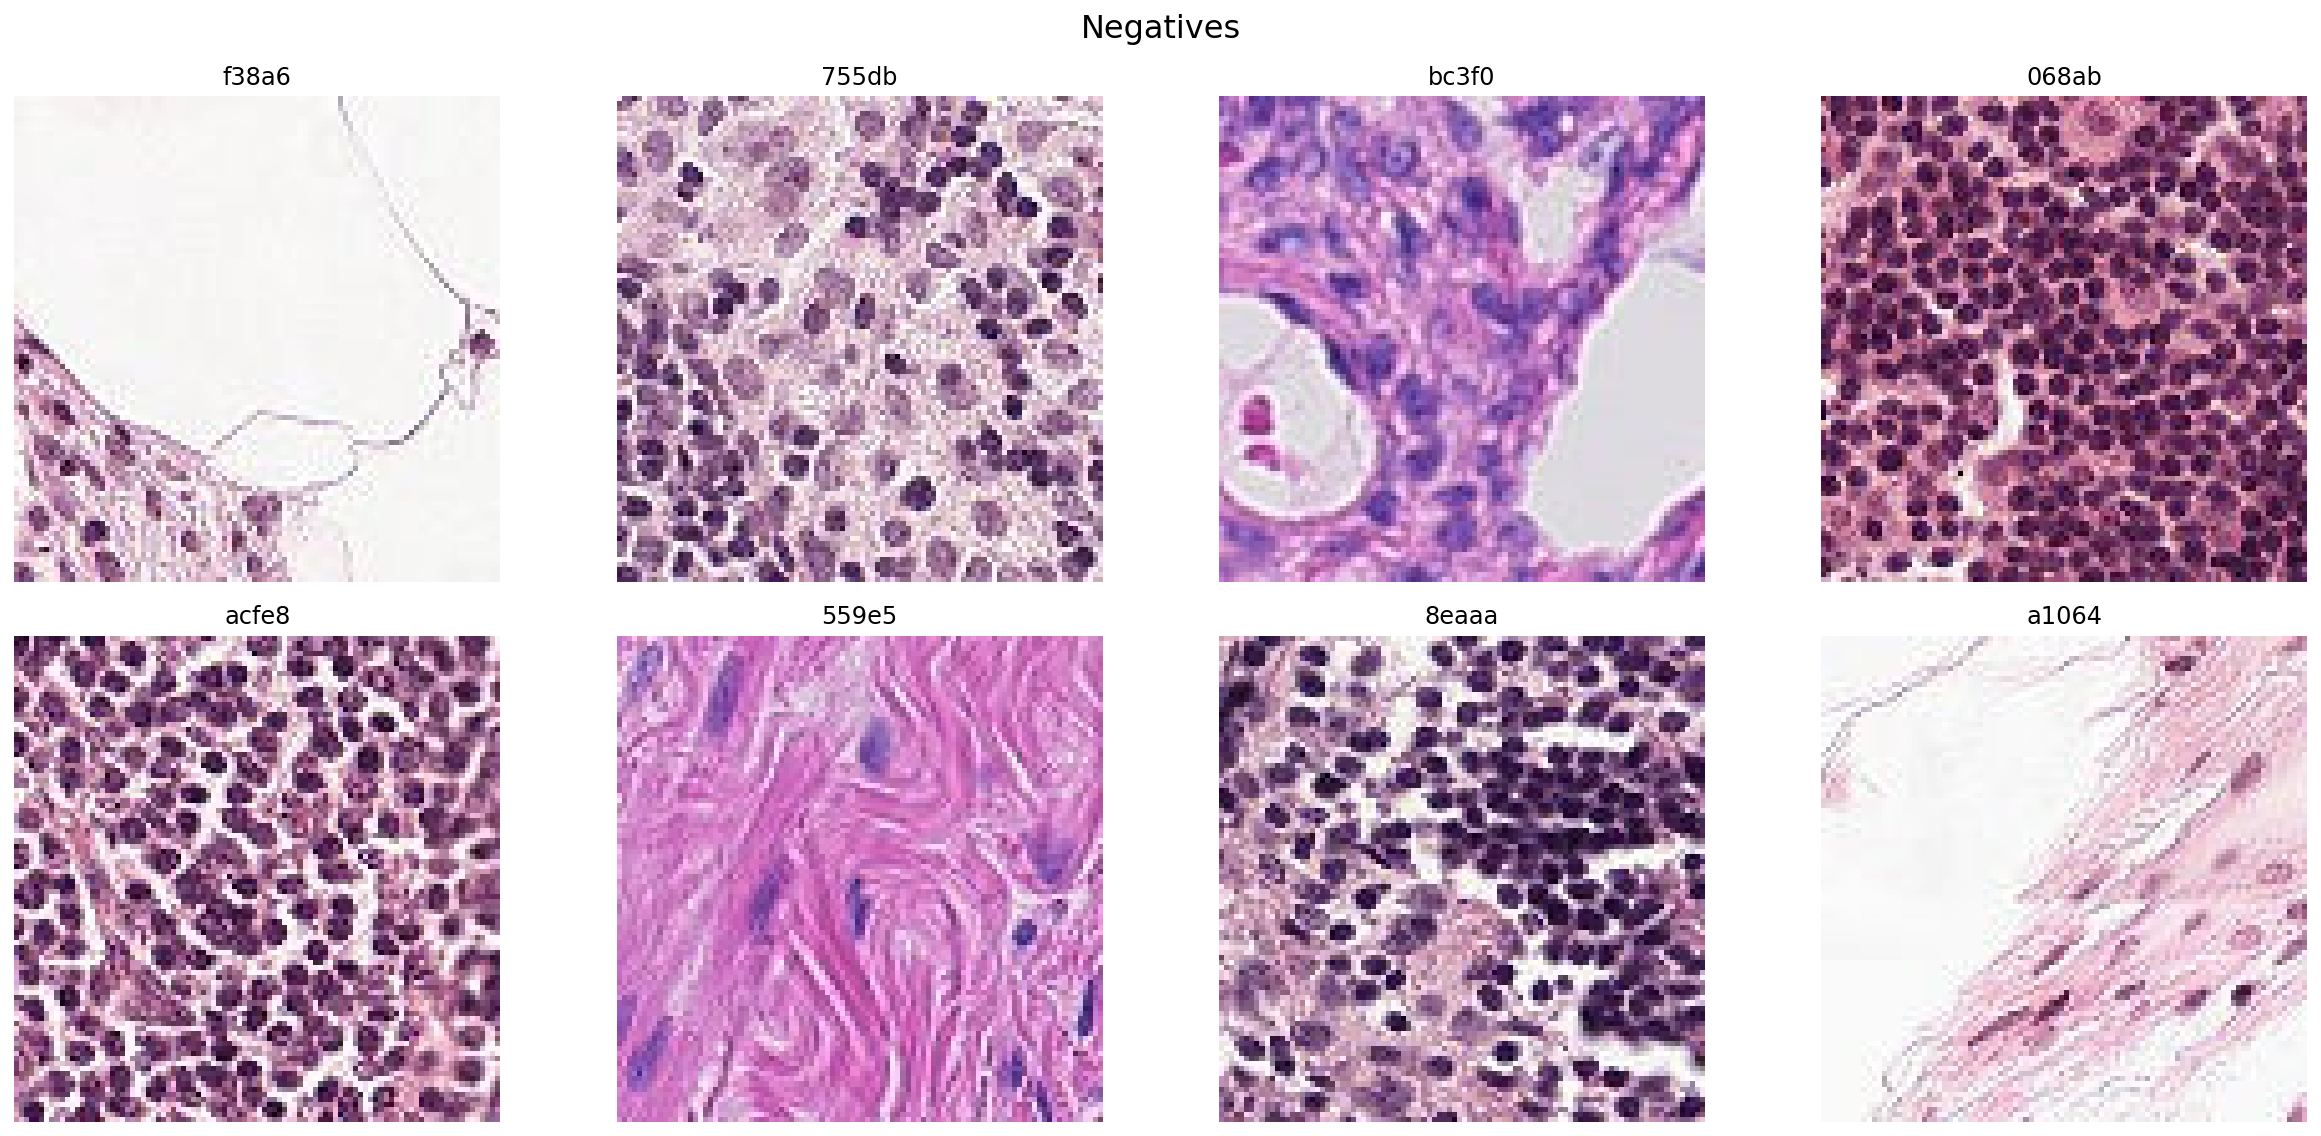

In [14]:
show8(TRAIN_DIR, ids[0][:8], 'Negatives')

### Positive Images

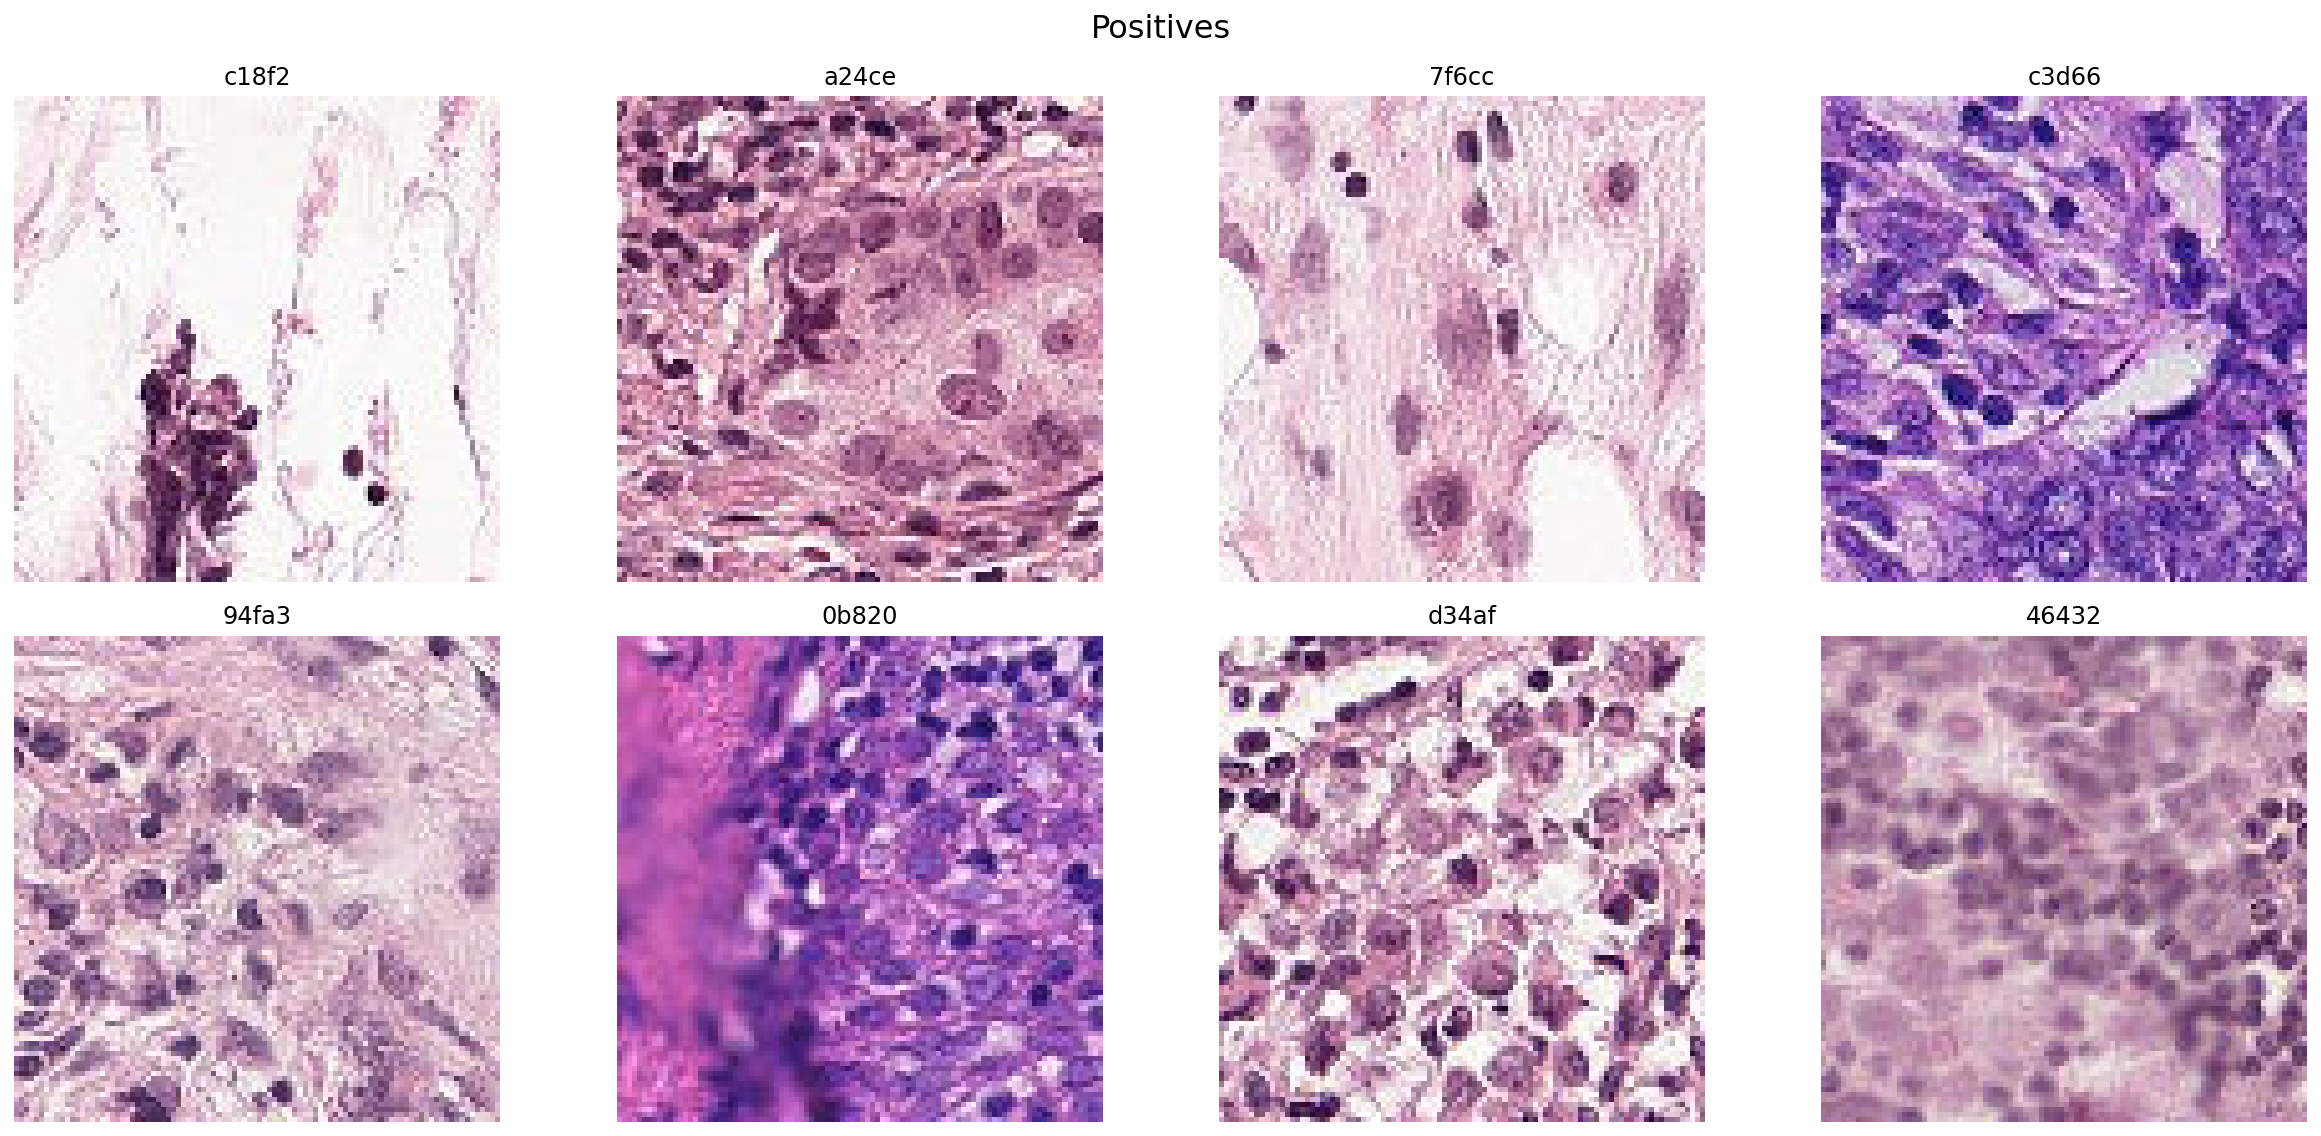

In [15]:
show8(TRAIN_DIR, ids[1][:8], 'Positives')

## (L\*A\*B) Color Space

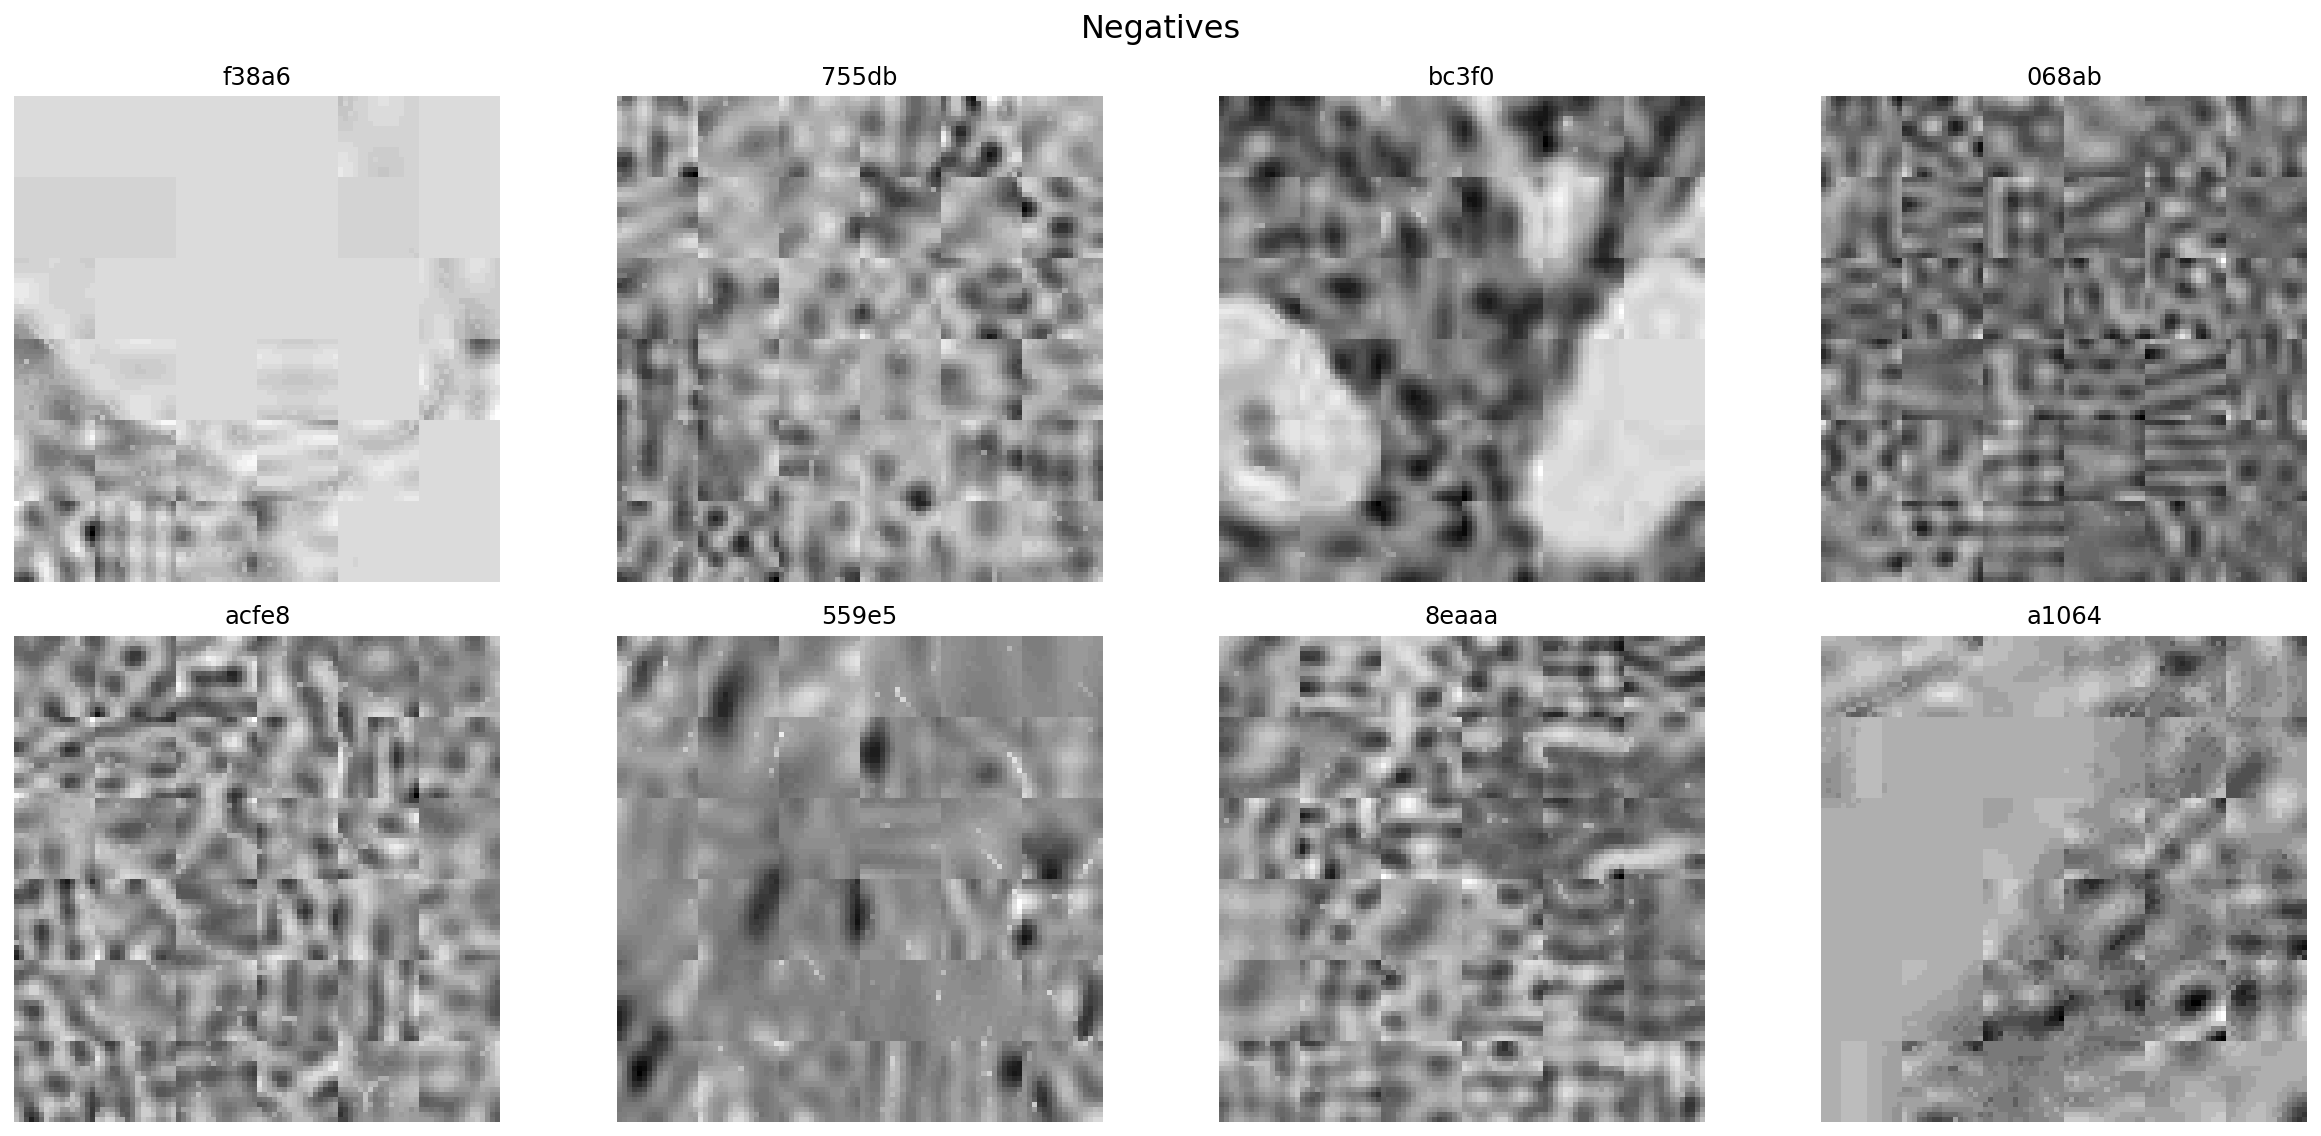

In [16]:
show8(TRAIN_DIR, ids[0][:8], 'Negatives', cv2.COLOR_RGB2Lab, 2)

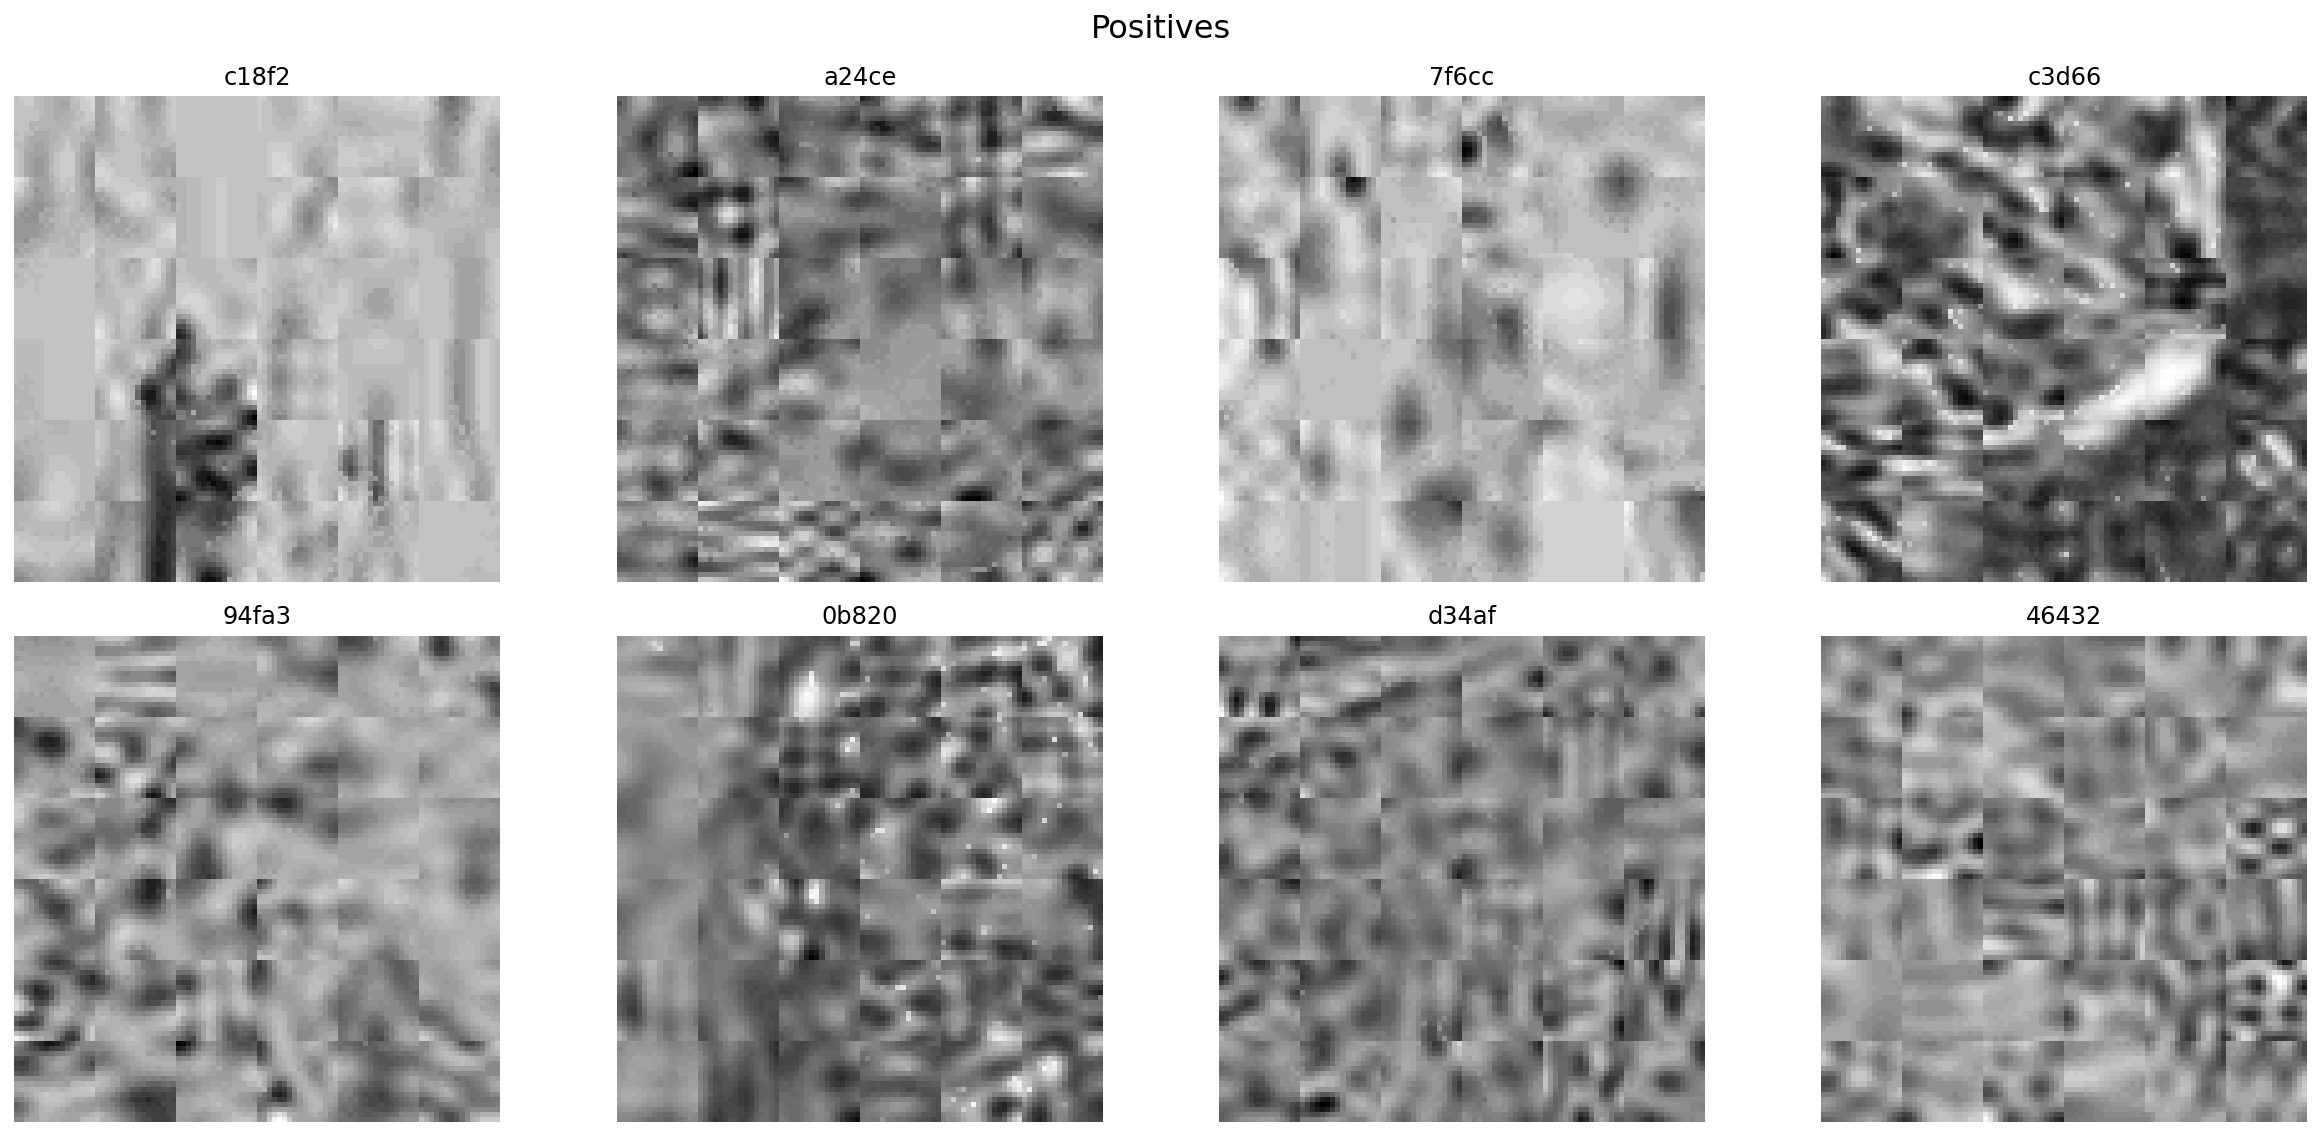

In [17]:
show8(TRAIN_DIR, ids[1][:8], 'Positives', cv2.COLOR_RGB2Lab, 2)

## Haematoxylin-Eosin-DAB (HED) Color Space

In [18]:
# The HED color deconv, rgb2hed(), produces values outside of 0 and 1 for some images.
# Workaround - use hed2rgb() with each HED channel separately and then run rgb2gray()
# on that conversion result
def rgb2hed_u8(img_rgb: np.ndarray) -> np.ndarray:
    assert img_rgb.dtype == 'uint8'
    assert img_rgb.shape[2] == 3
    img_hed = rgb2hed(img_rgb)
    img_z = np.zeros(img_rgb.shape[:2])
    img_h = img_as_ubyte(rgb2gray(hed2rgb(np.stack((img_hed[:, :, 0], img_z, img_z), axis=-1))))
    img_e = img_as_ubyte(rgb2gray(hed2rgb(np.stack((img_z, img_hed[:, :, 1], img_z), axis=-1))))
    img_d = img_as_ubyte(rgb2gray(hed2rgb(np.stack((img_z, img_z, img_hed[:, :, 2]), axis=-1))))
    img_hed = np.stack((img_h, img_e, img_d), axis=-1)
    return img_hed

In [19]:
def show_hed(img, max_val=(255, 255, 255)):
    img = rgb2hed_u8(img)
    _, ((ax1, ax2, ax3), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(17,8))
    ax1.imshow(img[:, :, 0], cmap='gray')
    ax2.imshow(img[:, :, 1], cmap='gray')
    ax3.imshow(img[:, :, 2], cmap='gray')
    ax21.hist(img[:, :, 0].ravel(), np.arange(2, max_val[0]))
    ax22.hist(img[:, :, 1].ravel(), np.arange(2, max_val[0]))
    ax23.hist(img[:, :, 2].ravel(), np.arange(2, max_val[0]))

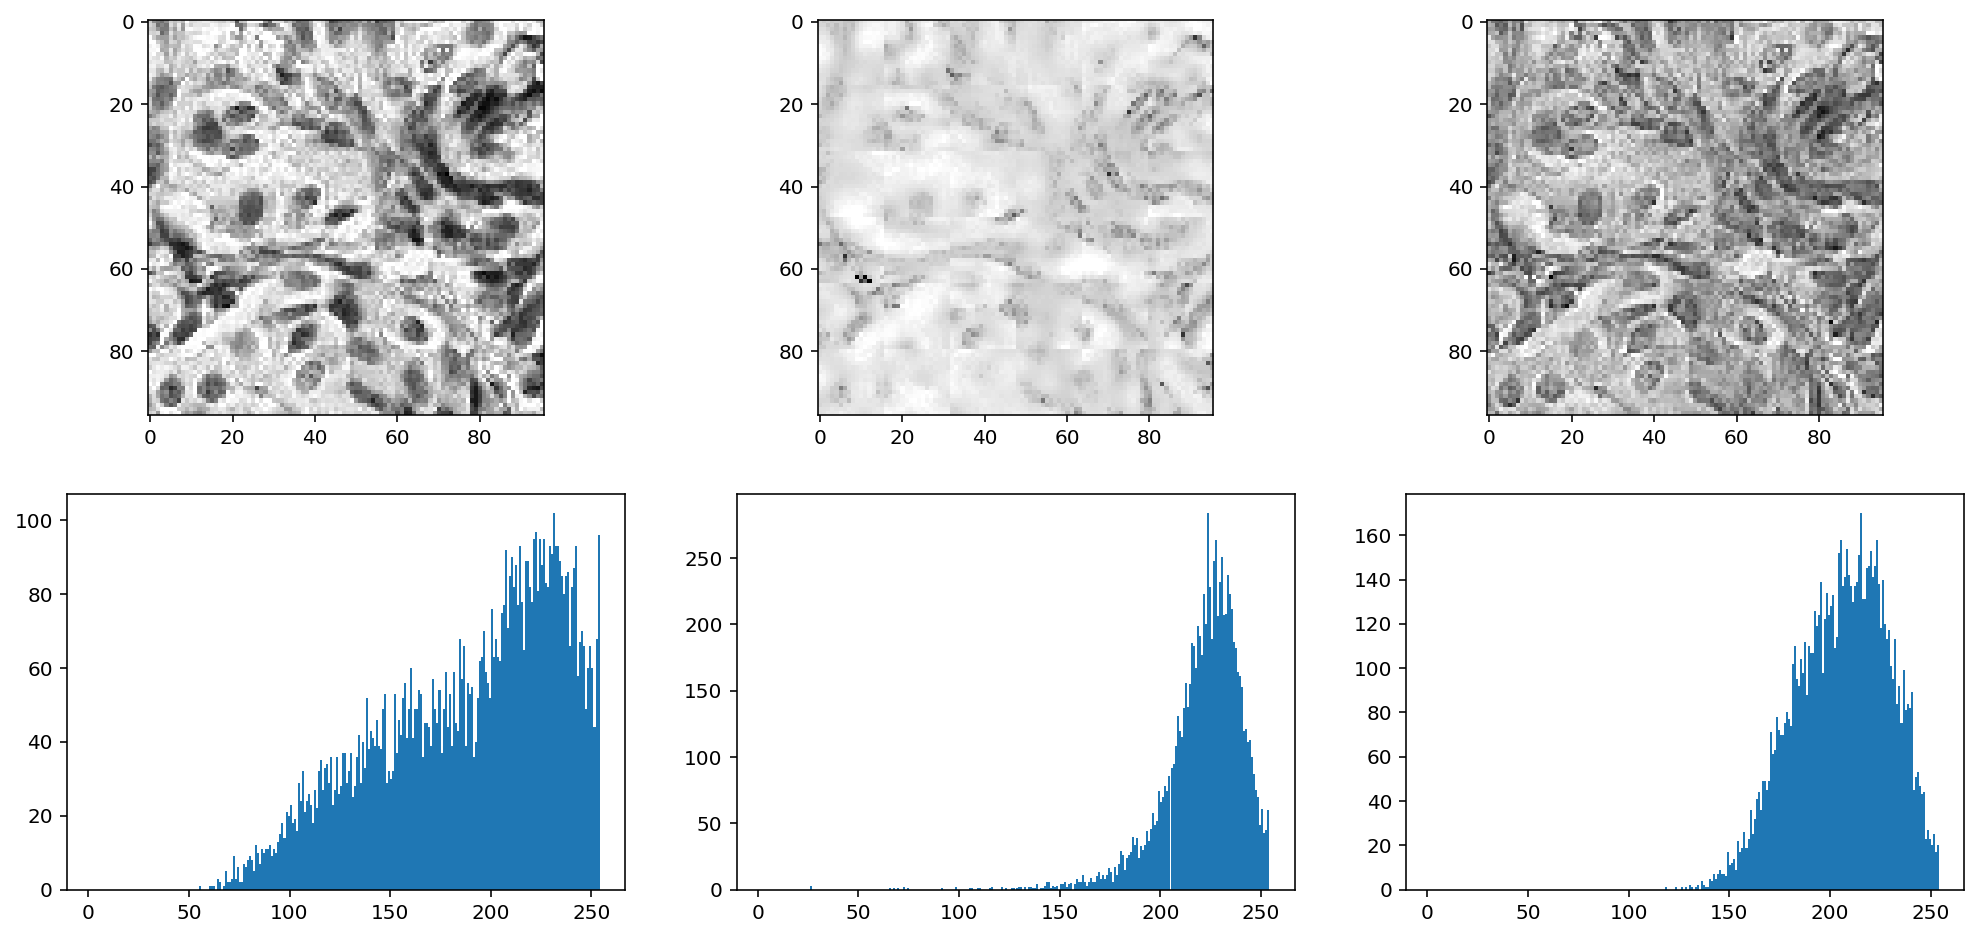

In [20]:
show_hed(imread(TRAIN_DIR + TRAIN_FILES[1]))